# Text Preprocessing: Partisan Tweets

## What are we doing?

Twitter is a rich source of information, often encapsulating complex ideas...


In [2]:
profound = """<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">hmm well I&#39;d say I&#39;m fiscally conservative but socially very liberal. the problems are bad but their causes...their causes are very good</p>&mdash; 🍍 Dollars Horton 🍍 (@crushingbort) <a href="https://twitter.com/crushingbort/status/463132110006784000">May 5, 2014</a></blockquote> <script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>"""
informative = """<blockquote class="twitter-tweet" data-lang="en"><p lang="und" dir="ltr">oh <a href="http://t.co/6opBB8HX8E">pic.twitter.com/6opBB8HX8E</a></p>&mdash; jon hendren (@fart) <a href="https://twitter.com/fart/status/627556581136207873">August 1, 2015</a></blockquote> <script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>"""
friendly = """<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">The only problem I have with Mitch McConnell is that, after hearing Repeal &amp; Replace for 7 years, he failed!That should NEVER have happened!</p>&mdash; Donald J. Trump (@realDonaldTrump) <a href="https://twitter.com/realDonaldTrump/status/900714982823821313">August 24, 2017</a></blockquote> <script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>"""

In [3]:
Tweet(profound)

...spreading information (with all essential context)...

In [4]:
Tweet(informative)

...or even helping form critical alliances.

In [5]:
Tweet(friendly)

Our elected representatives (or, more often, their staff) are some of the most prolific tweeters in the twitterverse, and their collective tweets can provide us with valuable insight into the language and ideas that separate us politically.

This data set contains a corpus of tweets from the accounts of U.S. Congressmen and Congresswomen over a ten week period from 6/21/2017 to 9/3/2017. While partisan language can be found in the tweets of most Americans, the particular words that are used by non-politicians to express political ideas often come from elected officials and their campaigns. Furthermore, politicians disproportionately use political speech in their tweets as compared with non-politicians, creating a purer source of political language to analyze.

We will use this corpus to ultimately build a classifier that can identify, with some degree of confidence, the political affiliation of the tweeter. If successful, potential applications of this model range from simply fun (e.g., a web service that determines your partisan lean based on your tweets) to enlightening (e.g., analyses that reveal the level of partisanship of think tanks or intermediary organizations).

Given that many of the tweets may not contain strictly political subject matter, or may be disproportionately focused on nonpartisan events (e.g., Hurricane Harvey), we do not expect the classifier to achieve high accuracy in its predictions, most likely less than 50%. Future efforts may include first distinguishing tweets based on their subject matter and collecting a larger and more evenly distributed sample of tweets that encapsulate more generally the nature of American political discourse.

## Preparing the Data for Analysis

Tweets are messy.

They contain URLs to articles, images, videos; key words or characters that carry special meaning (#, @, RT, QT); and often contain poorly placed punctuation and mispellings. In order to derive any insight from them, tweets must be thoroughly cleaned: stripped of URLs, key words, and punctuation, and tokenized to allow for frequency and importance representations.

### Load and Create Data Set

In [1]:
#import files
import numpy as np # array handling
import pandas as pd # data munging
import pickle # data loading/storing
import re # regular expressions

from PIL import Image #conda install -c anaconda pillow 
from wordcloud import WordCloud #conda install -c conda-forge wordcloud 

# Hide warnings
import warnings
warnings.filterwarnings("ignore")

# Plot settings
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import matplotlib as matplotlib
import seaborn as sns
import squarify #pip install squarify

%matplotlib inline
pylab.rcParams['figure.figsize'] = 16, 16

# Allow long strings to wrap to next line in HTML table
pd.options.display.max_colwidth = 0

# To embed tweets (https://github.com/jupyter/notebook/issues/2790)
class Tweet(object):
    def __init__(self, embed_str=None):
        self.embed_str = embed_str

    def _repr_html_(self):
        return self.embed_str

In [6]:
# Utility functions to be used later on
def intersect(a, b):
    """ return the intersection of two lists """
    return list(set(a) & set(b))

def union(a, b):
    """ return the union of two lists """
    return list(set(a) | set(b))

The tweets were web-scraped from Alex Litel's website (https://alexlitel.github.io/congresstweets/), which contains up-to-date tweets from all members of Congress that have an active Twitter account. In order to identify party affiliation, we then scraped Twitter's official list of Congressional Twitter handles (https://twitter.com/cspan/lists/members-of-congress/members?lang=en), and utilized a database created by the Sunlight Foundation for research purposes (http://unitedstates.sunlightfoundation.com/legislators/legislators.csv).

We then combined the tweets and party affiliation into a single data set for analysis.

In [7]:
# Load data set containing tweets and web-scraped Twitter handles / party affiliation
pkl_file = open("data/data.pkl", "rb")
data = pickle.load(pkl_file)
pkl_file.close()

# Separate dictionary into Series/Dataframes
tweets = data["tweets"]
republicans = [republican.lower() for republican in data["republicans"]]
democrats = [democrat.lower() for democrat in data["democrats"]]
scraped_handles = pd.DataFrame.from_dict({"twitter_id": republicans+democrats,
                                      "party": ["R"]*len(republicans)+["D"]*len(democrats)
                                     })

In [8]:
# Import list of current US Representatives/Senators
legislators = pd.read_csv("http://unitedstates.sunlightfoundation.com/legislators/legislators.csv")
official_handles = legislators.loc[legislators.twitter_id.notnull(), ['twitter_id', 'party']]

# Merge official handles with web-scraped handles and standardize (set to lower case)
twitter_handles = official_handles.append(scraped_handles)
twitter_handles['twitter_id'] = twitter_handles.twitter_id.str.lower()
twitter_handles.drop_duplicates(inplace = True)

# Clean up twitter handles (some of the web-scraped handles had special characters)
twitter_handles['twitter_id'] = twitter_handles.twitter_id.str.replace(r"(@|\?lang=en)", "")

# Convert tweets.screen_name to lowercase for effective merging
tweets['screen_name'] = tweets.screen_name.str.lower()

# Left join tweets w/ party identification
df_full = pd.merge(tweets, twitter_handles, left_on='screen_name', right_on='twitter_id', how='left')

Since we performed a *left join* with the two data sets, we can observe how many of the Twitter handles in our congressmen dictionary matched those in our *tweets* data set. Based on the info below, we successfully identified the party affiliation of the author of 89,780 of the 126,473 tweets in our data set.

In [9]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126473 entries, 0 to 126472
Data columns (total 8 columns):
id             126473 non-null int64
link           126473 non-null object
screen_name    126473 non-null object
source         126473 non-null object
text           126473 non-null object
time           126473 non-null object
party          89780 non-null object
twitter_id     89780 non-null object
dtypes: int64(1), object(7)
memory usage: 8.7+ MB


Let's take a look at the individuals for whom we were unable to identify party affiliation programmatically.

In [10]:
# List unique Twitter handles not identified with legislators data set
unknown = df_full.loc[df_full.party.isnull(), ['screen_name', 'party']]
unknown.screen_name.unique()[1:100]

array(['donjbacon', 'mattgaetz', 'bensasse', 'standwithraul',
       'tulsigabbard', 'tedcruz', 'auctnr1', 'gt_teamgt', 'bradyfortexas',
       'sessionsfortx32', 'johnkdelaney', 'corybooker', 'darrensoto',
       'flores4congress', 'chrismurphyct', 'rogermarshallmd',
       'garrettforva', 'marcorubio', 'davebratva7th', 'cartwrightpa',
       'lutherstrange', 'barbaracomstock', 'rokhanna', 'edworkforcedems',
       'jeffmerkley', 'sethmoulton', 'chriscoons', 'jiminhofe',
       'annlwagner', 'kamalaharris', 'transport', 'kristinoem',
       'dickdurbin', 'judgejohncarter', 'timkaine', 'teamsheaporter',
       'dinatitus', 'pramilajayapal', 'congpeteking', 'rogerwicker',
       'jimmygomezca', 'evanjenkinswv', 'norma4congress', 'scotttaylorva',
       'househomeland', 'liz_cheney', 'deanheller', 'jaredhuffman',
       'lacyclaymo1', 'amyklobuchar', 'rondesantisfl', 'pryan',
       'houseforeign', 'tedlieu', 'latta4congress', 'repblumenauer',
       'duffy4wisconsin', 'lloyddoggetttx', 

Many of these appear to be twitter handles for political campaigns, political groups, or personal handles for the members that were not identified in our web-scraping effort. In the future, we could expand our list of Twitter users to effectively label a greater proportion of tweets, but for now, we will go ahead and remove those tweets without a positive identification.

In [11]:
# Remove tweets from members without party identification
df = df_full.drop('screen_name', axis=1)
df = df[df.twitter_id.notnull()]
df = df.reset_index(drop=True)
df.shape

(89780, 7)

So we have 89,780 tweets in our final data set. We can observe how many Congress(wo)men are represented in the data.

In [12]:
#quantify republicans/democrats
print("%s democrats are represented" % df.twitter_id[df.party == "D"].unique().size)
print("%s republicans are represented" % df.twitter_id[df.party == "R"].unique().size)
print("%s independents are represented" % df.twitter_id[df.party == "I"].unique().size)
#print("%s are unknown" % len(set(tweets.screen_name.str.lower())-set(union(republicans, democrats))))

230 democrats are represented
286 republicans are represented
2 independents are represented


### Cleaning and Feature Engineering

Retweets, quote tweets, and replies may have different classification properties than original tweets. We may want to use this information down the road when we build our classifier, so we will go ahead and distinguish between the tweet types.

In [13]:
# Add new column to distinguish between types of tweets
df['tweet_type'] = 'original'
df.tweet_type[df.text.str.match(r"(^RT)")] = 'retweet'
df.tweet_type[df.text.str.contains("QT")] = 'quote_tweet'
df.tweet_type[df.text.str.match(r"(^@)")] = 'reply'

We will also collect the *URLs*, *mentions*, and *hashtags* in separate columns so that we may reference when we begin modeling. Finally, we will add an indicator column for whether the tweet contains an image and determine the true length of the tweet with special characters and URLs removed.

In [14]:
# Extract website of linked content
websites = df.text.str.extractall(r"https?://(www\.)?(.*?)/.*\b")[1]

# Indicate whether tweet contains an image
images = df.text.str.contains(r"\.(jpe?g|png|gif|bmp)")

# Extract handles of replies or mentions
handles = df.text.str.replace(r"http.?://[^\s]+[\s]?", "")
handles = handles.str.extractall(r"(?P<handle>@\S+\b)").reset_index().groupby("level_0")["handle"].apply(lambda x: ' '.join(x)).reset_index()
handles.columns = ["tweet_index", "handles"]

# Extract hashtags
hashtags = df.text.str.replace(r"http.?://[^\s]+[\s]?", "")
hashtags = hashtags.str.extractall(r"(?P<hashtag>#\S+\b)").reset_index().groupby("level_0")["hashtag"].apply(lambda x: ' '.join(x)).reset_index()
hashtags.columns = ["tweet_index", "hashtags"]

# Determine true tweet length with URLs, handles, RT/QT, and hashtags removed
clean_text_length = df.text.str.replace(r"http.?://[^\s]+[\s]?", "") # remove urls
clean_text_length = clean_text_length.str.replace(r"QT @.*", "") # remove QT
clean_text_length = clean_text_length.str.replace(r"@[^\s]+[\s]?", "") # remove handles
clean_text_length = clean_text_length.str.replace("^RT", "") # remove RT
clean_text_length = clean_text_length.str.replace("[^A-Za-z0-9\s]", "") # keep characters only
clean_text_length = clean_text_length.str.len()

In order to have clean text from which to create a bag of words or TF-IDF representation, we need to remove URLs, indicators such as RT and QT, and other special characters from the tweets. We will store these in a separate column so that we can reference back to the original text in the future.

In [15]:
# Strip non-essential information from tweets (URLs, RT/QT, HTML, special characters)
clean_text = df.text.str.replace(r"http.?://[^\s]+[\s]?", "") # remove urls
clean_text = clean_text.str.replace(r"@[^\s]+[\s]?", "") # remove handles
clean_text = clean_text.str.replace(r"&.+\b", "") # remove HTML markup: &amp; &lt;
clean_text = clean_text.str.replace(r"\n", " ") # replace \n with space
clean_text = clean_text.str.replace(r"^RT", "") # remove RT
clean_text = clean_text.str.replace(r"\bQT\b", "") # remove QT
clean_text = clean_text.str.replace(r"[wW]/", "with") # convert 'w/' to 'with'
clean_text = clean_text.str.replace(r"[^A-Za-z0-9\s]", "") # keep characters only

df["clean_text"] = clean_text

## Exploring the Data

### Bag of Words

We will first create a *bag of words* representation of all of the text contained in our corpus of tweets. This will essentially tokenize each word and count the frequencies with which these words appear across all tweets. The data is stored in a sparse matrix, so that we can efficiently store it in memory.

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

# Create an instance of the CountVectorizer class for onegrams and bigrams
cv_onegram = CountVectorizer(analyzer="word", stop_words = "english", lowercase = True, 
                             token_pattern=r'\b\w+\b')
cv_bigram = CountVectorizer(analyzer="word", stop_words = "english", lowercase = True, 
                            token_pattern=r'\b\w+\b', ngram_range=(2,2))

# Create a sparse 'bag of words' matrix for all of the tweets
bag_onegram = cv_onegram.fit_transform(df.clean_text)
bag_bigram = cv_bigram.fit_transform(df.clean_text)

In [17]:
# Quick look at our sparse matrices
print("Onegram Matrix: " + str(bag_onegram.shape))
print(bag_onegram[0])
print('===========================')
print("Bigram Matrix: " + str(bag_bigram.shape))
print(bag_bigram[0])

Onegram Matrix: (89780, 48546)
  (0, 19440)	1
  (0, 11972)	1
  (0, 28649)	1
  (0, 8200)	1
  (0, 36428)	1
  (0, 20817)	1
  (0, 22334)	1
Bigram Matrix: (89780, 444491)
  (0, 91538)	1
  (0, 252281)	1
  (0, 54741)	1
  (0, 321405)	1
  (0, 174693)	1
  (0, 191856)	1


In [18]:
%%time

# Store word frequencies in a list
# source: https://stackoverflow.com/questions/16288497/find-the-most-common-term-in-scikit-learn-classifier
onegram_freqs = [(word, bag_onegram.getcol(idx).sum()) for word, idx in cv_onegram.vocabulary_.items()]
onegram_freqs = pd.DataFrame(onegram_freqs, columns=["Words", "Frequency"])
onegram_freqs = onegram_freqs.sort_values(by="Frequency", ascending=False).reset_index(drop = True)

CPU times: user 4min 6s, sys: 1.6 s, total: 4min 8s
Wall time: 4min 11s


With this, we can observe the most frequently used words in all of the tweets.

In [20]:
onegram_freqs[:10]

,Words,Frequency
0,today,6240
1,health,4935
2,great,4928
3,care,4676
4,trump,3951
5,thank,3446
6,house,3143
7,work,3119
8,people,3007
9,senate,2989


### TF-IDF

Although the *bag of words* matrix provides us with a sense of how often certain words occur in the corpus, this alone cannot provide us with much information about the importance of certain words. For instance, certain words appear in nearly every sentence in the English language. We should not interpret the frequency of appearance, in this case, as a measure of importance. Instead, we can construct a *TF-IDF* representation of the words in our corpus, which assesses how often a word may appear in a single document, while also deprioritizing those words that appear in all documents.

In [21]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer

# Convert to TF-IDF matrix
tfidf_vect = TfidfVectorizer(stop_words="english",
                             max_df=0.01,
                             min_df=4)
tfidf_mat = tfidf_vect.fit_transform(df.clean_text)

CPU times: user 1.38 s, sys: 23.7 ms, total: 1.4 s
Wall time: 1.4 s


In [22]:
# Quick look at our TF-IDF matrix
print("Dimensions: " + str(tfidf_mat.shape))
print('===========================')
print(tfidf_mat[0])

Dimensions: (89780, 14850)
  (0, 6855)	0.364920516829
  (0, 11167)	0.375746191558
  (0, 2259)	0.44534121583
  (0, 3522)	0.448731949826
  (0, 6025)	0.570927889155


In [23]:
# Convert the TF-IDF matrix to a DataFrame
df_tfidf  = pd.DataFrame(data=tfidf_mat.toarray(),columns=tfidf_vect.get_feature_names())

# Separate Republican and Democrat TF-IDFs
rep_tfidf = df_tfidf[df.party.reset_index(drop = True) == "R"]
dem_tfidf = df_tfidf[df.party.reset_index(drop = True) == "D"]

In [24]:
# Find the words with the greatest mean TF-IDF, separated by Repub/Dem
rep_top_tfidf = rep_tfidf.mean(axis=0).sort_values(ascending=False)[0:20]
dem_top_tfidf = dem_tfidf.mean(axis=0).sort_values(ascending=False)[0:20]
both_top_tfidf = union(dem_top_tfidf.index, rep_top_tfidf.index)

# Extract the mean TF-IDF for the top words for both groups
rep_mean_tfidf = rep_tfidf.mean(axis=0)
rep_mean_tfidf = rep_mean_tfidf[rep_mean_tfidf.index.isin(both_top_tfidf)]
dem_mean_tfidf = dem_tfidf.mean(axis=0)
dem_mean_tfidf = dem_mean_tfidf[dem_mean_tfidf.index.isin(both_top_tfidf)]

As we can see in the plot below, there is only minimal overlap between the most important words used by Republicans and Democrats. This may suggest that a proper classifier could, indeed, be constructed that could distinguish party affiliation based solely on the text of the individual's tweets.

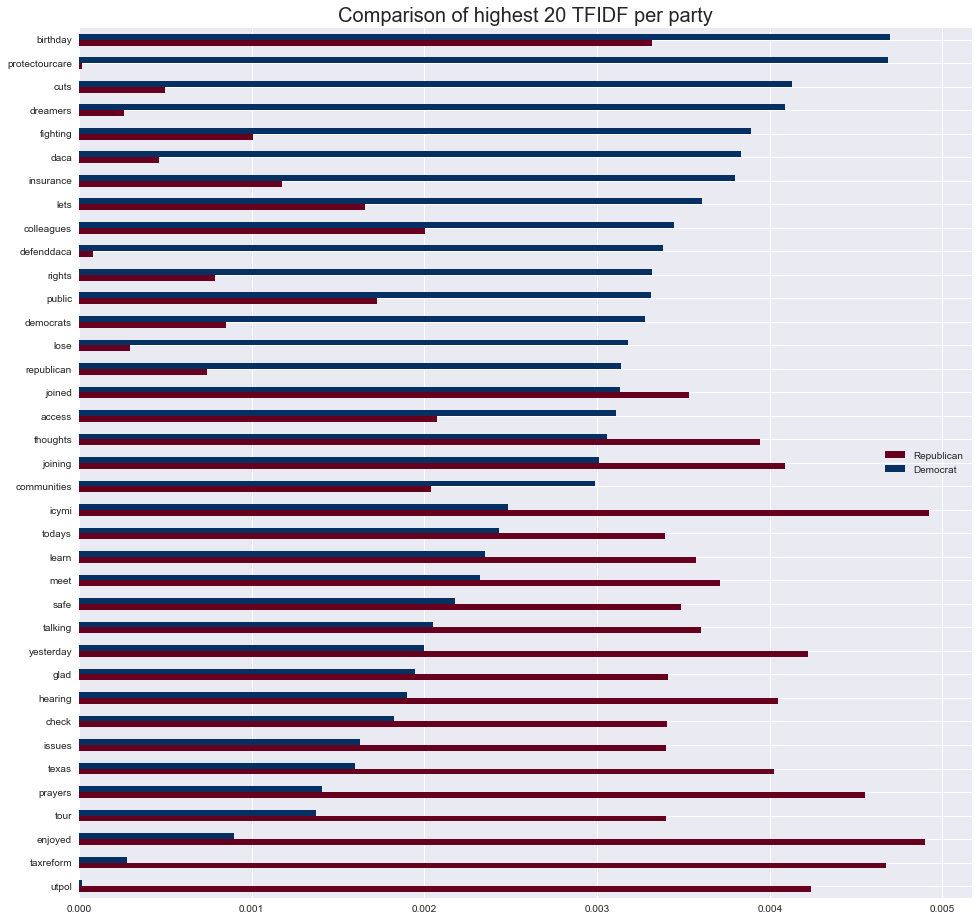

In [25]:
# Plot the mean TF-IDF values for each party
both_mean_tfidf = pd.concat([rep_mean_tfidf, dem_mean_tfidf], axis=1)
both_mean_tfidf.columns = ["Republican", "Democrat"]
both_mean_tfidf = both_mean_tfidf.sort_values(by = "Democrat")
both_mean_tfidf.plot.barh(colormap = cm.RdBu)
plt.title("Comparison of highest 20 TFIDF per party", fontsize=20)
plt.show()

While the device used to compose a tweet is not likely to have much practical import, it is nevertheless interesting to see if there is a difference in device usage between Republicans, Independents, and Democrats. It appears that Democrats (at least in our sample) tend to tweet more often from the Twitter Web Client than Republicans, which likely means that it is the legislator's staff composing the tweet. This sample, however, is certainly not representative, so no conclusions should be drawn from this.

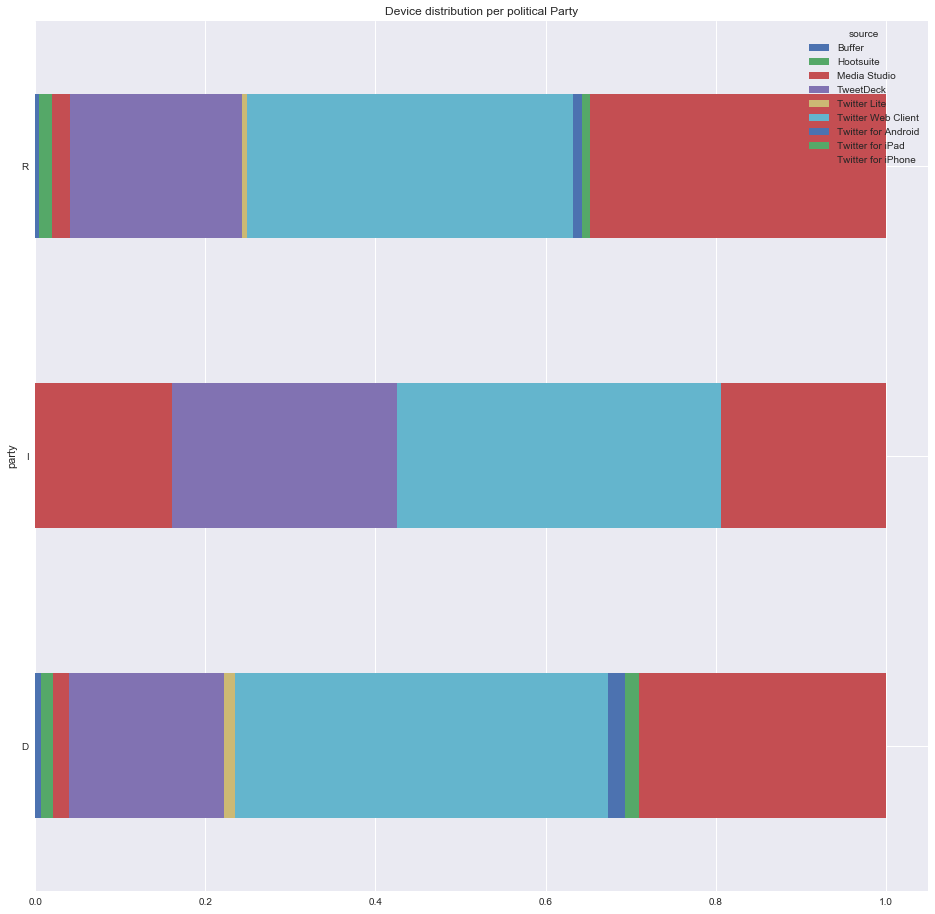

In [27]:
df_plot = pd.crosstab(df.party[df.source.isin(df.source.value_counts()[0:9].index)],
                      df.source[df.source.isin(df.source.value_counts()[0:9].index)])
df_plot = df_plot.div(df_plot.sum(axis=1).astype(float),axis=0) # normalize the value

p = df_plot.plot(kind='barh', stacked=True)
plt.title("Device distribution per political Party")
plt.show()

As we saw earlier, the 10 highest tf-idf words for democrats are "birthday, protectourcare, fighting, daca, cuts, dreamers, colleagues, lets, leaders, lose". Now we'd like to observe the frequency of these words for each party.

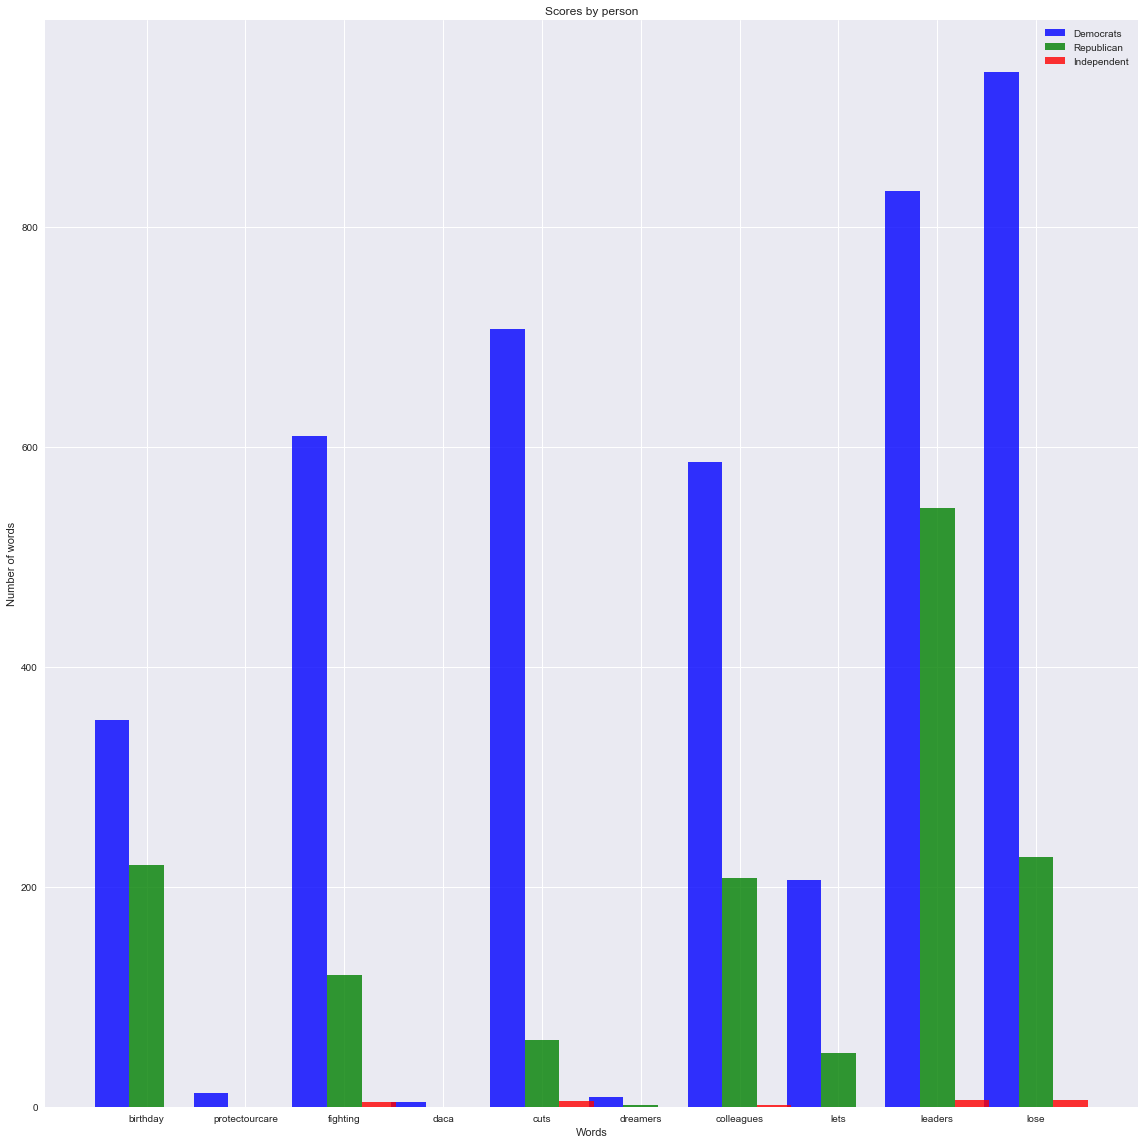

In [28]:
#highest tf-idf words for democrats by each party
democrat_word_frequency_num=[0,0,0,0,0,0,0,0,0,0]
most_used_words=["birthday", "protectourcare", "fighting", "daca", "cuts", "dreamers", "colleagues", "lets", "leaders", "lose"]
for j in range(10):
    for i in range(len(df)):
        if most_used_words[j] in df.clean_text.iloc[i] and df.party.iloc[i] == "D":
            democrat_word_frequency_num[j]=democrat_word_frequency_num[j]+1
            
republican_word_frequency_num=[0,0,0,0,0,0,0,0,0,0]
most_used_words=["birthday", "protectourcare", "fighting", "daca", "cuts", "dreamers", "colleagues", "lets", "leaders", "lose"]
for j in range(10):
    for i in range(len(df)):
        if most_used_words[j] in df.clean_text.iloc[i] and df.party.iloc[i] == "R":
            republican_word_frequency_num[j]=republican_word_frequency_num[j]+1
            
independent_word_frequency_num=[0,0,0,0,0,0,0,0,0,0]
most_used_words=["birthday", "protectourcare", "fighting", "daca", "cuts", "dreamers", "colleagues", "lets", "leaders", "lose"]
for j in range(10):
    for i in range(len(df)):
        if most_used_words[j] in df.clean_text.iloc[i] and df.party.iloc[i] == "I":
            independent_word_frequency_num[j]=independent_word_frequency_num[j]+1
            

fig, ax = plt.subplots()
index = np.arange(10)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index - bar_width, democrat_word_frequency_num, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Democrats')
 
rects2 = plt.bar(index, republican_word_frequency_num, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Republican')

rects3 = plt.bar(index + bar_width, independent_word_frequency_num, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Independent')
 
plt.xlabel('Words')
plt.ylabel('Number of words')
plt.title('Scores by person')
plt.xticks(index, ("birthday", "protectourcare", "fighting", "daca", "cuts", "dreamers", "colleagues", "lets", "leaders", "lose"))
plt.legend()
 
plt.tight_layout()
plt.show()



Now we do the same thing for highest tf-idf words for republicans.
These words include: "enjoyed, county, taxreform, joining, prayers, honor, yesterday, meet, issues, learn".

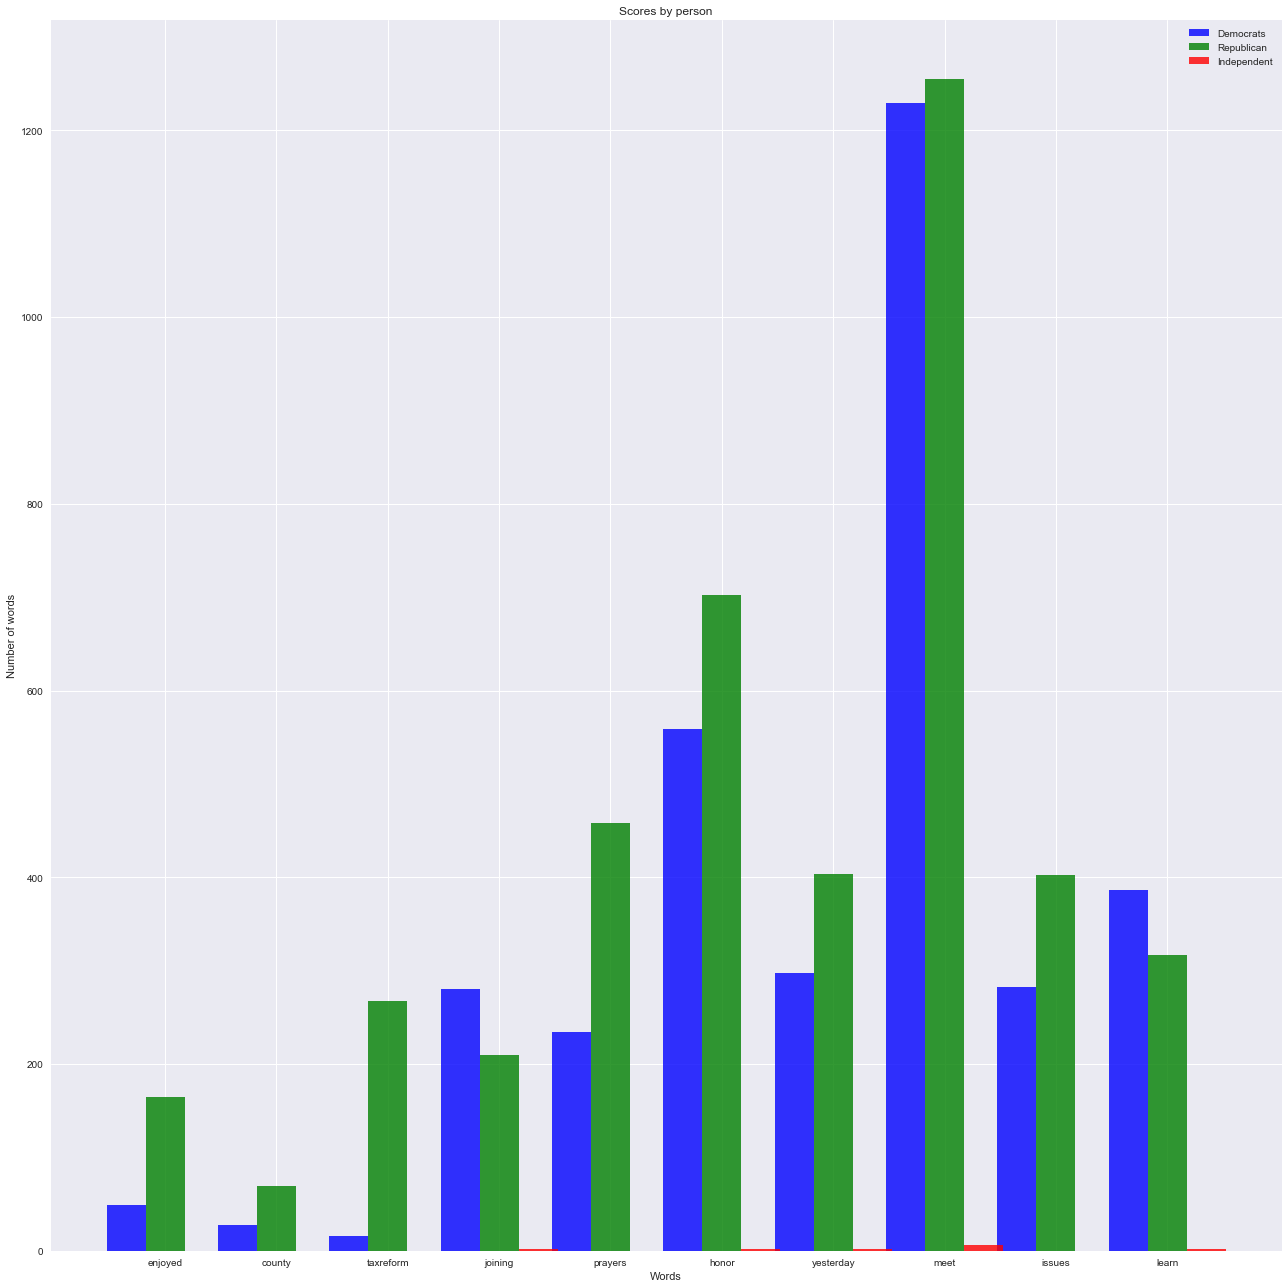

In [41]:
#highest tf-idf words for Republicans by each party
democrat_word_frequency_num=[0,0,0,0,0,0,0,0,0,0]
most_used_words=["enjoyed", "county", "taxreform", "joining", "prayers", "honor", "yesterday", "meet", "issues", "learn"]
for j in range(10):
    for i in range(len(df)):
        if most_used_words[j] in df.clean_text.iloc[i] and df.party.iloc[i] == "D":
            democrat_word_frequency_num[j]=democrat_word_frequency_num[j]+1
            
republican_word_frequency_num=[0,0,0,0,0,0,0,0,0,0]
most_used_words=["enjoyed", "county", "taxreform", "joining", "prayers", "honor", "yesterday", "meet", "issues", "learn"]
for j in range(10):
    for i in range(len(df)):
        if most_used_words[j] in df.clean_text.iloc[i] and df.party.iloc[i] == "R":
            republican_word_frequency_num[j]=republican_word_frequency_num[j]+1
            
independent_word_frequency_num=[0,0,0,0,0,0,0,0,0,0]
most_used_words=["enjoyed", "county", "taxreform", "joining", "prayers", "honor", "yesterday", "meet", "issues", "learn"]
for j in range(10):
    for i in range(len(df)):
        if most_used_words[j] in df.clean_text.iloc[i] and df.party.iloc[i] == "I":
            independent_word_frequency_num[j]=independent_word_frequency_num[j]+1
            

fig, ax = plt.subplots()
index = np.arange(10)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index - bar_width, democrat_word_frequency_num, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Democrats')
 
rects2 = plt.bar(index, republican_word_frequency_num, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Republican')

rects3 = plt.bar(index + bar_width, independent_word_frequency_num, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Independent')
 
plt.xlabel('Words')
plt.ylabel('Number of words')
plt.title('Scores by person')
plt.xticks(index, ("enjoyed", "county", "taxreform", "joining", "prayers", "honor", "yesterday", "meet", "issues", "learn"))
plt.legend()
 
plt.tight_layout()
plt.show()

#### Hashtags

Let's see if there's a difference in the kinds of hashtags that our elected representatives employ in their tweets. But first, let's take a look at the most common hashtags employed during our analysis period (6/30/17 - 9/3/17).

In [31]:
# Tokenize the hashtags we extracted from tweets earlier and put them in a DataFrame
hashtag_cv = CountVectorizer(analyzer="word", stop_words = "english", lowercase = True)
hashtag_bw = hashtag_cv.fit_transform(hashtags.hashtags)
hashtag_bw = pd.DataFrame(data=hashtag_bw.toarray(),
                          columns=hashtag_cv.get_feature_names())

In [32]:
# Count number of appearances
bipartisan_hashtags = hashtag_bw.sum()
bipartisan_hashtags = bipartisan_hashtags.sort_values(ascending=False)

# Separate hashtags by party
democrat_hashtags = hashtag_bw[df.party.reset_index(drop = True)=="D"].sum()
democrat_hashtags = democrat_hashtags.sort_values(ascending=False)
republican_hashtags = hashtag_bw[df.party.reset_index(drop = True)=="R"].sum()
republican_hashtags = republican_hashtags.sort_values(ascending=False)

In [33]:
# Extract only the most popular hashtags to visualize
bipart_ht = bipartisan_hashtags[bipartisan_hashtags > 200]
dem_ht = democrat_hashtags[democrat_hashtags > 200]
repub_ht = republican_hashtags[republican_hashtags > 200]

In [34]:
def create_treemap(series, cmap):
    #params
    x = 0
    y = 0
    width = 100
    height = 100
    #cmap = matplotlib.cm.Blues        

    #colors
    mini, maxi = series.min(), series.max()
    norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
    #norm = matplotlib.colors.NoNorm(vmin=mini, vmax=maxi)
    colors = [cmap(norm(value)) for value in series.values]
    #colors[1] = "#FBFCFE"

    #labels
    labels = ["#%s\n%d mentions" % (label) for label in zip(series.index, series.values)]

    #plot
    fig = plt.figure(figsize=(16, 16))    
    ax = fig.add_subplot(111, aspect="equal")
    ax = squarify.plot(series.values, color=colors, label=labels, ax=ax, alpha=.7)        
    ax.set_xticks([])
    ax.set_yticks([])    
    return(fig)

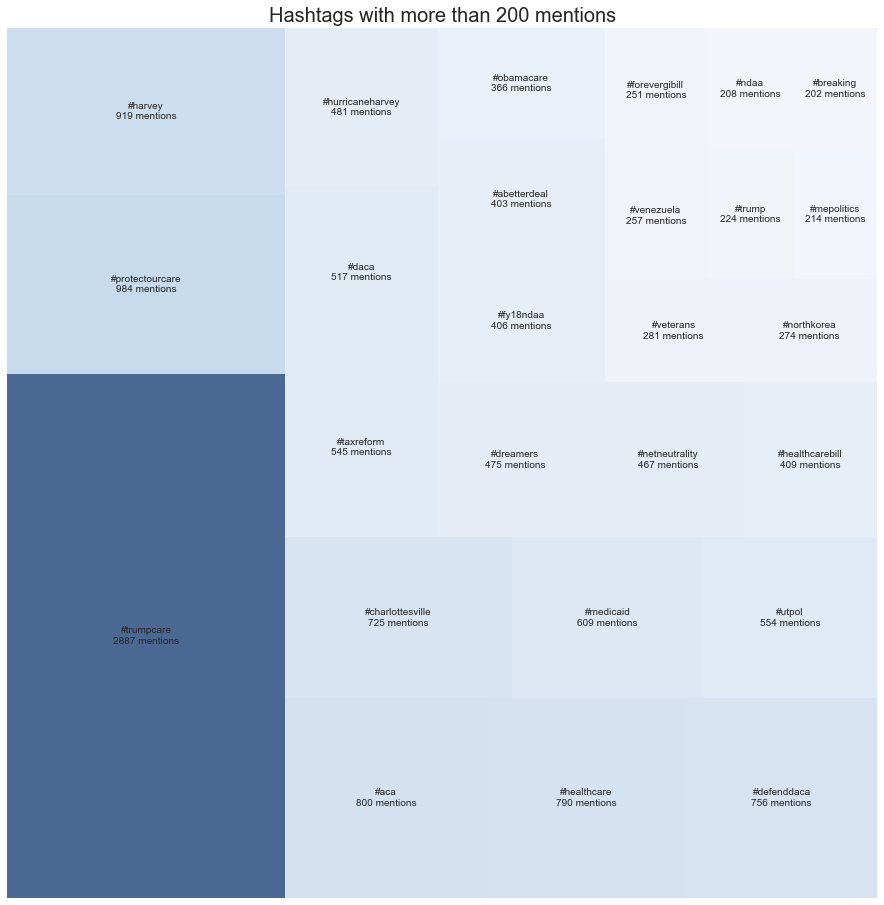

In [35]:
fig = create_treemap(bipart_ht, matplotlib.cm.Blues)
plt.title("Hashtags with more than 200 mentions", fontsize=20)

plt.show()

Since our period included the peak debate around the Republican healthcare bill, the #TrumpCare hashtag is unsurprisingly the most common, followed by #ProtectOurCare (another healthcare hashtag) and #Harvey, which also occurred during our collection period.

Let's see how the two parties differ in their treatment of these topics.

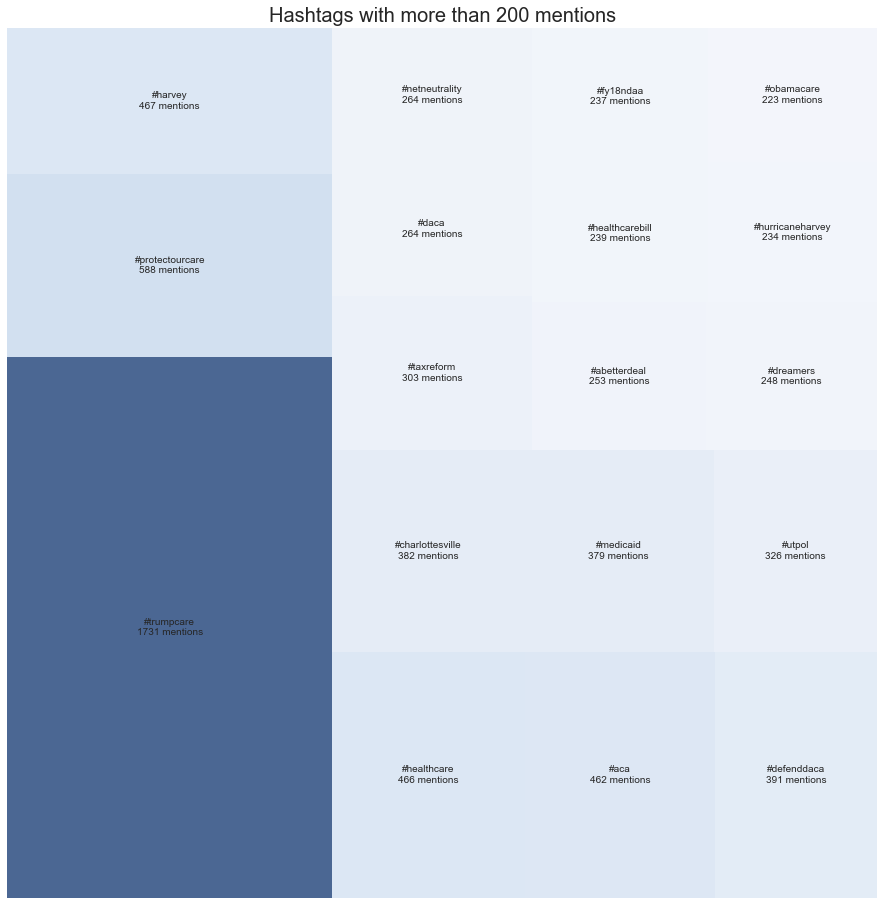

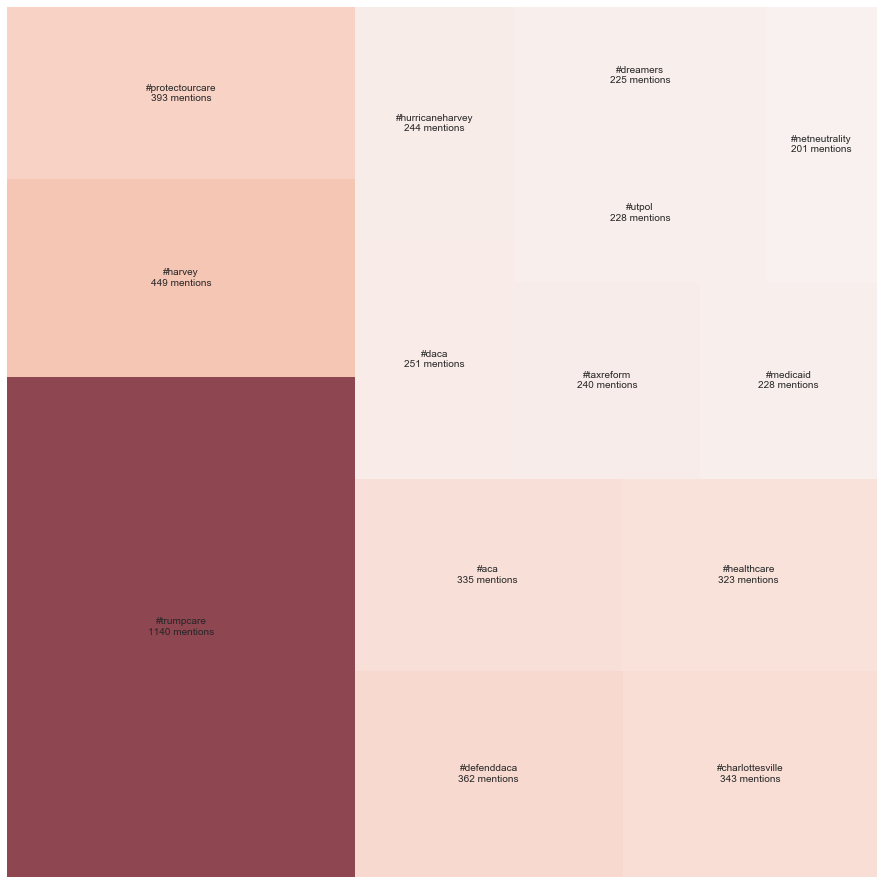

In [38]:
fig = create_treemap(dem_ht, matplotlib.cm.Blues)
plt.title("Hashtags with more than 200 mentions", fontsize=20)

fig = create_treemap(repub_ht, matplotlib.cm.Reds)

plt.show()

While both parties employed the #TrumpCare hashtag more than any other, there were some notable differences between the parties. For instance, #ABetterDeal, the Democrats' new jobs-focused party slogan, did not make Republicans' list of top hashtags.

#### Word Clouds!

Let's see to what extent Democrats and Republicans use different words in their tweets. We expect to see some variation between the two parties in the things that they emphasize, which will enable us to build a useful classifier down the road.

In [39]:
# Create a masked word cloud
def create_wordcloud(text, n, color, mask):
    cv = CountVectorizer(analyzer="word", stop_words = "english", lowercase = True, 
                             token_pattern=r'\b\w+\b', ngram_range=(n,n))
    
    def white_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        return "white"
    
    wc_df = pd.DataFrame(data=cv.fit_transform(text).toarray(),
                           columns=cv.get_feature_names())
    wc_df = wc_df.sum().sort_values()
    wc_df = list(zip(wc_df.index.values, wc_df.values))
    
    wordcloud = WordCloud(background_color=color, mask=mask).fit_words(wc_df)
    wordcloud.recolor(color_func=white_color_func, random_state=3)
    return(wordcloud)

# Colors for respective parties
democrat_color = "#3333FF"
republican_color = "#EE3523"

# Image of donkey and elephant for Dems/Repubs, respectively
democrat_mask = np.array(Image.open("img/democrat_silhouette.png"))
republican_mask = np.array(Image.open("img/republican_silhouette.png"))

# Separate out the tweets by party
democrat_text = df.clean_text[df.party == "D"][1:5000]
republican_text = df.clean_text[df.party == "R"][1:5000]

In [40]:
# Some basic parameters to set up the word cloud grid
pylab.rcParams['figure.figsize'] = 18, 18
gs1 = gridspec.GridSpec(2, 2)
gs1.update(wspace=0, hspace=0) # set the spacing between axes. 

A great way to view the differences in language between the parties is to look at a word cloud. In the bigram version, you can observe the difference in concepts between Democrats ("ending daca", "joe arpaio") and Republicans ("tax reform", "tax code").

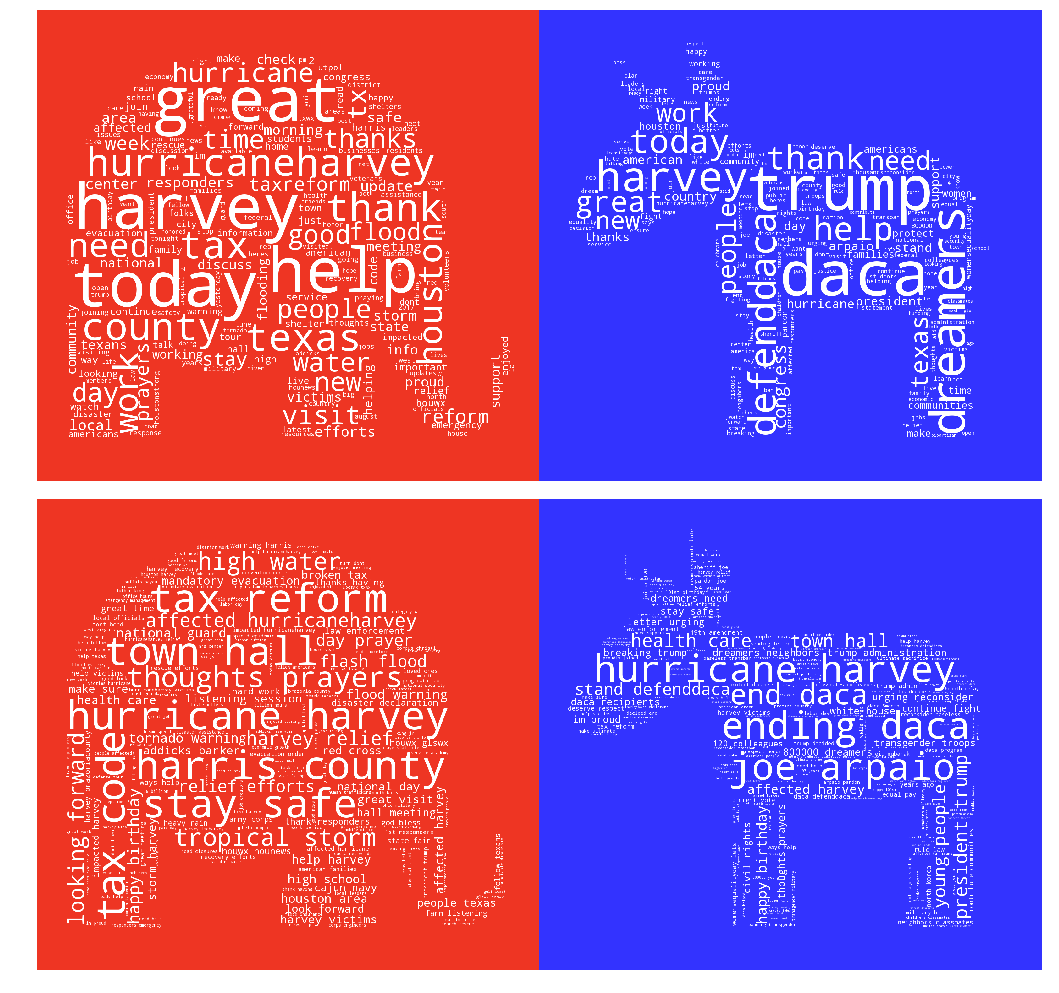

In [42]:
# Single words
plt.subplots(nrows=2, ncols=2)#, figsize=(18, 9))
a = plt.subplot(gs1[0])#2,2,1)
plt.imshow(create_wordcloud(republican_text, 1, republican_color, republican_mask))
plt.axis("off")
a = plt.subplot(gs1[1])#2,2,2)
plt.imshow(create_wordcloud(democrat_text, 1, democrat_color, democrat_mask))
plt.axis("off")

# Now with bigrams!
a = plt.subplot(gs1[2])#2,2,3)
plt.imshow(create_wordcloud(republican_text, 2, republican_color, republican_mask))
plt.axis("off")
a = plt.subplot(gs1[3])#2,2,4)
plt.imshow(create_wordcloud(democrat_text, 2, democrat_color, democrat_mask))
plt.axis("off")
plt.show()
pylab.rcParams['figure.figsize'] = 16, 16

#### *FEEL THE BERN* 🔥

Bernie, of course, sticks to his familiar themes: health care, climate change, and ... "Bernie Sanders"?

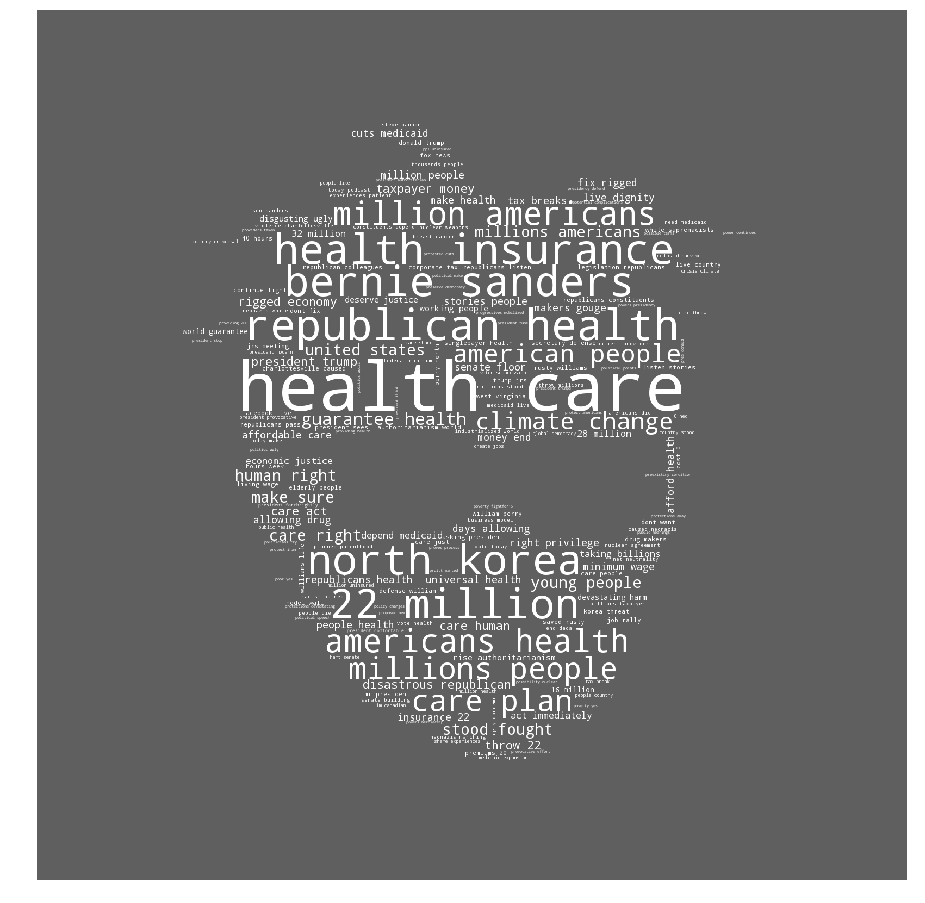

In [43]:
# Bernie
independent_color = "#5F5F5F"
independent_text = df.clean_text[df.twitter_id == "sensanders"]
independent_mask = np.array(Image.open("img/bernie_silhouette.png"))
independent_wordcloud = create_wordcloud(independent_text, 2, independent_color, independent_mask)
plt.imshow(independent_wordcloud)
plt.axis("off")
plt.show()